# Modeling 

In [20]:
# Imports:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.decomposition import PCA

%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Import pre-imputed dataset 
df= pd.read_csv("../../data/pre_imputed.csv")
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
print(df.shape)

(13969, 117)


In [3]:
df.head(5)

,federal_provider_number,total_deaths_per_1000,total_cases_per_1000,2020_cases_per_1000,2020_deaths_per_1000,2021_cases_per_1000,2021_deaths_per_1000,provider_city,provider_zip_code,provider_county_name,number_of_certified_beds,average_number_of_residents_per_day,provider_resides_in_hospital,date_first_approved_to_provide_medicare_and_medicaid_services,continuing_care_retirement_community,abuse_icon,most_recent_health_inspection_more_than_2_years_ago,provider_changed_ownership_in_last_12_months,automatic_sprinkler_systems_in_all_required_areas,overall_rating,health_inspection_rating,qm_rating,staffing_rating,rn_staffing_rating,reported_nurse_aide_staffing_hours_per_resident_per_day,reported_lpn_staffing_hours_per_resident_per_day,reported_rn_staffing_hours_per_resident_per_day,reported_licensed_staffing_hours_per_resident_per_day,reported_total_nurse_staffing_hours_per_resident_per_day,reported_physical_therapist_staffing_hours_per_resident_per_day,adjusted_nurse_aide_staffing_hours_per_resident_per_day,adjusted_lpn_staffing_hours_per_resident_per_day,adjusted_rn_staffing_hours_per_resident_per_day,adjusted_total_nurse_staffing_hours_per_resident_per_day,total_weighted_health_survey_score,number_of_facility_reported_incidents,number_of_substantiated_complaints,number_of_citations_from_infection_control_inspections,number_of_fines,total_amount_of_fines_in_dollars,number_of_payment_denials,total_number_of_penalties,percent_vaccinated_residents,percent_vaccinated_healthcare_personnel,rural_versus_urban,overhead_non-salary_costs,total_charges,total_costs,wage-related_costs_(core),total_salaries_(adjusted),total_assets,accounts_payable,"salaries,_wages,_and_fees_payable",total_liabilities,total_fund_balances,total_general_inpatient_care_services_revenue,inpatient_revenue,gross_revenue,net_patient_revenue,less_total_operating_expense,net_income_from_service_to_patients,total_income,net_income,provider_state_ar,provider_state_az,provider_state_ca,provider_state_co,provider_state_ct,provider_state_de,provider_state_fl,provider_state_ga,provider_state_gu,provider_state_hi,provider_state_ia,provider_state_id,provider_state_il,provider_state_in,provider_state_ks,provider_state_ky,provider_state_la,provider_state_ma,provider_state_md,provider_state_me,provider_state_mi,provider_state_mn,provider_state_mo,provider_state_ms,provider_state_mt,provider_state_nc,provider_state_nd,provider_state_ne,provider_state_nj,provider_state_nm,provider_state_nv,provider_state_ny,provider_state_oh,provider_state_ok,provider_state_or,provider_state_pa,provider_state_pr,provider_state_ri,provider_state_sc,provider_state_sd,provider_state_tn,provider_state_tx,provider_state_ut,provider_state_va,provider_state_vt,provider_state_wa,provider_state_wi,provider_state_wv,provider_state_wy,ownership_type_government,ownership_type_non_profit,with_a_resident_and_family_council_family,with_a_resident_and_family_council_none,with_a_resident_and_family_council_resident
0,15009,188.68,1811.32,905.66,94.34,905.66,94.34,RUSSELLVILLE,35653,Franklin,57,53.2,0,1969,0,0,1,1,1.0,5.0,5.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.333,0,0,0.0,0,0.00,0,0,NaN,NaN,0.0,2151372.0,936818.0,610630.0,414202.0,2426400.0,1724846.0,89387.0,101599.0,184933.0,1539913.0,4395342.0,5332160.0,5332160.0,4727863.0,4601512.0,126351.0,135292.0,135292.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15010,59.11,571.40,295.08,32.79,276.32,26.32,SYLACAUGA,35150,Talladega,85,72.5,0,1967,0,0,1,1,1.0,4.0,3.0,4.0,5.0,5.0,2.69344,0.91942,0.90290,1.82232,4.51576,0.01307,2.82510,1.04987,1.27671,4.98569,18.667,0,0,0.0,1,650.00,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15012,190.47,698.42,392.86,107.14,305.56,83.33,SCOTTSBORO,35768,Jackson,50,40.3,1,1967,0,0,1,1,1.0,1.0,2.0,3.0,1.0,1.0,

In [4]:
## Add in new features, drop remaining outliers
df["rating_exp"]=(df["overall_rating"]+df["health_inspection_rating"]+df["qm_rating"]+df["staffing_rating"]+df["rn_staffing_rating"])**2
df1= df.loc[df['total_deaths_per_1000'] <= 3500]
df1.shape

(13967, 118)

In [5]:
variables=[
#"federal_provider_number",
"total_deaths_per_1000",
#"total_cases_per_1000",
#"2020_cases_per_1000",
#"2020_deaths_per_1000",
#"2021_cases_per_1000",
#"2021_deaths_per_1000",
#"provider_city",
#"provider_zip_code",
#"provider_county_name",
"number_of_certified_beds",
"average_number_of_residents_per_day",
"provider_resides_in_hospital",
"date_first_approved_to_provide_medicare_and_medicaid_services",
"continuing_care_retirement_community",
"abuse_icon",
"most_recent_health_inspection_more_than_2_years_ago",
"provider_changed_ownership_in_last_12_months",
"automatic_sprinkler_systems_in_all_required_areas",
"overall_rating",
"health_inspection_rating",
"qm_rating",
"staffing_rating",
"rn_staffing_rating",
"reported_nurse_aide_staffing_hours_per_resident_per_day",
"reported_lpn_staffing_hours_per_resident_per_day","reported_rn_staffing_hours_per_resident_per_day",
"reported_licensed_staffing_hours_per_resident_per_day",
"reported_total_nurse_staffing_hours_per_resident_per_day",
"reported_physical_therapist_staffing_hours_per_resident_per_day",
"adjusted_nurse_aide_staffing_hours_per_resident_per_day",
"adjusted_lpn_staffing_hours_per_resident_per_day",
"adjusted_rn_staffing_hours_per_resident_per_day",
"adjusted_total_nurse_staffing_hours_per_resident_per_day",
"total_weighted_health_survey_score",
"number_of_facility_reported_incidents",
"number_of_substantiated_complaints",
"number_of_citations_from_infection_control_inspections",
"number_of_fines",
"total_amount_of_fines_in_dollars",
"number_of_payment_denials",
"total_number_of_penalties",
"percent_vaccinated_residents",
"percent_vaccinated_healthcare_personnel",
"rural_versus_urban",
#"overhead_non-salary_costs",
#"total_charges",
#"total_costs",
"wage-related_costs_(core)",
#"total_salaries_(adjusted)",
#"total_assets",
#"accounts_payable",
"salaries,_wages,_and_fees_payable",
"total_liabilities",
#"total_fund_balances",
#"total_general_inpatient_care_services_revenue",
#"inpatient_revenue",
#"gross_revenue",
"net_patient_revenue",
#"less_total_operating_expense",
"net_income_from_service_to_patients",
#"total_income",
"net_income",
"provider_state_ar",
"provider_state_az",
"provider_state_ca",
"provider_state_co",
"provider_state_ct",
"provider_state_de",
"provider_state_fl",
"provider_state_ga",
"provider_state_gu",
"provider_state_hi",
"provider_state_ia",
"provider_state_id",
"provider_state_il",
"provider_state_in",
"provider_state_ks",
"provider_state_ky",
"provider_state_la",
"provider_state_ma",
"provider_state_md",
"provider_state_me",
"provider_state_mi",
"provider_state_mn",
"provider_state_mo",
"provider_state_ms",
"provider_state_mt",
"provider_state_nc",
"provider_state_nd",
"provider_state_ne",
"provider_state_nj",
"provider_state_nm",
"provider_state_nv",
"provider_state_ny",
"provider_state_oh",
"provider_state_ok",
"provider_state_or",
"provider_state_pa",
"provider_state_pr",
"provider_state_ri",
"provider_state_sc",
"provider_state_sd",
"provider_state_tn",
"provider_state_tx",
"provider_state_ut",
"provider_state_va",
"provider_state_vt",
"provider_state_wa",
"provider_state_wi",
"provider_state_wv",
"provider_state_wy",
"ownership_type_government",
"ownership_type_non_profit",
"with_a_resident_and_family_council_family",
"with_a_resident_and_family_council_none",
"with_a_resident_and_family_council_resident",
#"rating_exp"
              ]
df2=df1[variables]
#pd.set_option('display.max_rows', None)
#df2.isnull().sum()


In [7]:
#write out final dataset for reference
df2.to_csv("../../data/finalmodeling.csv")

In [6]:
features = [col for col in df2 if col not in ('total_deaths_per_1000')]
X=df2[features]
y=df2['total_deaths_per_1000']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75,random_state=42)

### Impute Missing Values

In [8]:
#First lets get around our missing values by using knn for X train 

knn_imp = KNNImputer()

knn_imp_data_missing = knn_imp.fit_transform(X_train)

X_train_imp_knn = pd.DataFrame(knn_imp_data_missing, columns = X_train.columns)

In [9]:
#First lets get around our missing values by using knn for X test

knn_imp = KNNImputer()

knn_imp_data_missing_test = knn_imp.fit_transform(X_test)

X_test_imp_knn = pd.DataFrame(knn_imp_data_missing_test, columns = X_test.columns)

In [11]:
#reassign variable names
X_train=X_train_imp_knn
X_test=X_test_imp_knn 

## Modeling

In [12]:
sc=StandardScaler()
X_train_sc= sc.fit_transform(X_train)
X_test_sc=sc.transform(X_test)

In [13]:
# Fit Linear Regression

linreg1 = LinearRegression()
linreg1.fit(X_train_sc,y_train)
lr_preds_train=linreg1.predict(X_train_sc)
lr_preds_test=linreg1.predict(X_test_sc)
print(f"Training Score: {linreg1.score(X_train_sc, y_train)}")
print(f"Testing Score: {linreg1.score(X_test_sc, y_test)}")
print("------")
print(f"Training RMSE: {metrics.mean_squared_error(y_train,lr_preds_train, squared=False)}")
print(f"Testing RMSE: {metrics.mean_squared_error(y_test,lr_preds_test, squared=False)}")
print("------")
print(f"Training MAE: {metrics.mean_absolute_error(y_train,lr_preds_train)}")
print(f"Testing MAE: {metrics.mean_absolute_error(y_test,lr_preds_test)}")

Training Score: 0.06610047978432332
Testing Score: 0.06467047542430371
------
Training RMSE: 233.6235026390718
Testing RMSE: 237.83482151927387
------
Training MAE: 162.7266050978132
Testing MAE: 165.89501647024372


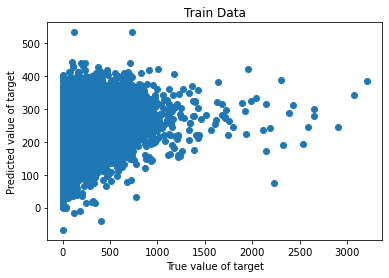

In [14]:
# Plot y vs predictions (Training)
plt.scatter(y_train, lr_preds_train)
plt.xlabel("True value of target")
plt.ylabel("Predicted value of target")
plt.title('Train Data');
plt.show()

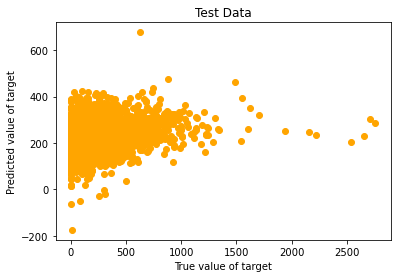

In [15]:
# Plot y vs predictions (Test)
plt.scatter(y_test,lr_preds_test,c='orange');
plt.xlabel("True value of target")
plt.ylabel("Predicted value of target")
plt.title('Test Data');
plt.show()

## Comparison to Baseline 

In [14]:
y_bar=np.mean(y)
null_mse=np.mean((y-y_bar)**2)
null_mse

58956.93646271887

In [15]:
null_rmse=np.sqrt(null_mse)
null_rmse

242.8104949599973

In [16]:
our_mse=metrics.mean_squared_error(y_test,lr_preds_test, squared=True)
our_mse

56565.40232710486

In [17]:
our_rmse=metrics.mean_squared_error(y_test,lr_preds_test, squared=False)
our_rmse

237.83482151927387

## Additional Modeling Methods

In [39]:
# PCA

pca = PCA(n_components=10, random_state = 42)

# Fit PCA to training data.
pca.fit(X_train_sc)

# Instantiate linear regression model.
lm = LinearRegression()

# Transform Z_train and Z_test.

Z_train = pca.transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

# Fit on Z_train.
lm.fit(Z_train, y_train)

lm_preds_train=lm.predict(Z_train)
lm_preds_test=lm.predict(Z_test)

# Score on training and testing sets.
print(f'Training Score: {round(lm.score(Z_train, y_train), 4)}')
print(f'Testing Score: {round(lm.score(Z_test, y_test), 4)}')
print("------")
print(f"Training RMSE: {metrics.mean_squared_error(y_train,lm_preds_train, squared=False)}")
print(f"Testing RMSE: {metrics.mean_squared_error(y_test,lm_preds_test, squared=False)}")
print("------")
print(f"Training MAE: {metrics.mean_absolute_error(y_train,lm_preds_train)}")
print(f"Testing MAE: {metrics.mean_absolute_error(y_test,lm_preds_test)}")

Training Score: 0.0114
Testing Score: 0.0151
------
Training RMSE: 240.3625186449481
Testing RMSE: 244.06085650138877
------
Training MAE: 169.36646111510487
Testing MAE: 172.0676664473666


In [46]:
# Fit KNN Regressor -  Scale Variables

knn_reg = KNeighborsRegressor()
knn_reg_params = {
    'n_neighbors': range(1, 51, 10),
    'weights':['uniform','distance']
}

gs_knn = GridSearchCV(knn_reg, param_grid=knn_reg_params,
                 cv = 5,
                 n_jobs = -1)

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

gs_knn.fit(X_train_sc, y_train)
knn_preds_train=gs_knn.predict(X_train_sc)
knn_preds_test=gs_knn.predict(X_test_sc)

print(gs_knn.best_params_)
print(f'Cross Val: {gs_knn.best_score_}')
print(f'Training Score: {gs_knn.score(X_train, y_train)}')
print(f'Testing Score: {gs_knn.score(X_test, y_test)}')
print("------")
print(f"Training RMSE: {metrics.mean_squared_error(y_train,knn_preds_train, squared=False)}")
print(f"Testing RMSE: {metrics.mean_squared_error(y_test,knn_preds_test, squared=False)}")
print("------")
print(f"Training MAE: {metrics.mean_absolute_error(y_train,knn_preds_train)}")
print(f"Testing MAE: {metrics.mean_absolute_error(y_test,knn_preds_test)}")

{'n_neighbors': 41, 'weights': 'distance'}
Cross Val: 0.03849510383780512
Training Score: -0.0449973620636277
Testing Score: -0.043473011756944846
------
Training RMSE: 0.0
Testing RMSE: 241.54177703429605
------
Training MAE: 0.0
Testing MAE: 168.1969527410477


In [19]:
# Fit Bagging Regressor

bag_reg = BaggingRegressor()
bag_reg_params = {
    'n_estimators': [100, 150, 200,250],
    'random_state':[42]
}

gs_bag = GridSearchCV(bag_reg, param_grid=bag_reg_params,
                 cv = 5,
                 n_jobs = -1)

gs_bag.fit(X_train, y_train)
bag_preds_train=gs_bag.predict(X_train)
bag_preds_test=gs_bag.predict(X_test)

print(gs_bag.best_params_)
print(f'Cross Val: {gs_bag.best_score_}')
print(f'Training Score: {gs_bag.score(X_train, y_train)}')
print(f'Testing Score: {gs_bag.score(X_test, y_test)}')
print("------")
print(f"Training RMSE: {metrics.mean_squared_error(y_train,bag_preds_train, squared=False)}")
print(f"Testing RMSE: {metrics.mean_squared_error(y_test,bag_preds_test, squared=False)}")
print("------")
print(f"Training MAE: {metrics.mean_absolute_error(y_train,bag_preds_train)}")
print(f"Testing MAE: {metrics.mean_absolute_error(y_test,bag_preds_test)}")

{'n_estimators': 200, 'random_state': 42}
Cross Val: 0.025909368065530257
Training Score: 0.8648469877415292
Testing Score: 0.04230439805772068
------
Training RMSE: 88.87493979283708
Testing RMSE: 240.66163616513262
------
Training MAE: 62.16925843914082
Testing MAE: 169.47300966494845


In [20]:
# Fit Decision Tree Regressor

dt_reg = DecisionTreeRegressor()
dt_reg_params = {
    'max_depth': [None, 1, 2, 3, 4, 5,7],
    'random_state': [42],
    'min_samples_leaf': range(1, 7),
    'min_samples_split': [2, 5, 10, 15, 20]
}

gs_dt = GridSearchCV(dt_reg, param_grid=dt_reg_params,
                 cv = 5,
                 n_jobs = -1)

gs_dt.fit(X_train, y_train)
dt_preds_train=gs_dt.predict(X_train)
dt_preds_test=gs_dt.predict(X_test)

print(gs_dt.best_params_)
print(f'Cross Val: {gs_dt.best_score_}')
print(f'Training Score: {gs_dt.score(X_train, y_train)}')
print(f'Testing Score: {gs_dt.score(X_test, y_test)}')
print("------")
print(f"Training RMSE: {metrics.mean_squared_error(y_train,dt_preds_train, squared=False)}")
print(f"Testing RMSE: {metrics.mean_squared_error(y_test,dt_preds_test, squared=False)}")
print("------")
print(f"Training MAE: {metrics.mean_absolute_error(y_train,dt_preds_train)}")
print(f"Testing MAE: {metrics.mean_absolute_error(y_test,dt_preds_test)}")

{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42}
Cross Val: 0.005792559562067678
Training Score: 0.014717840165648144
Testing Score: 0.0027466006409971877
------
Training RMSE: 239.96437113971126
Testing RMSE: 245.58163202378302
------
Training MAE: 169.22028092207324
Testing MAE: 172.42114535091014


In [22]:
#Fit XGBoost Regressor 

xg= XGBRegressor(random_state=42,eta=.1,min_child_weight=250)
xg.fit(X_train_sc,y_train)

xg_preds_train=xg.predict(X_train_sc)
xg_preds_test=xg.predict(X_test_sc)

xg.score(X_train_sc,y_train),xg.score(X_test_sc,y_test)

print(f'Training Score: {xg.score(X_train_sc,y_train)}')
print(f'Testing Score: {xg.score(X_test_sc,y_test)}')
print("------")
print(f"Training RMSE: {metrics.mean_squared_error(y_train,xg_preds_train, squared=False)}")
print(f"Testing RMSE: {metrics.mean_squared_error(y_test,xg_preds_test, squared=False)}")
print("------")
print(f"Training MAE: {metrics.mean_absolute_error(y_train,xg_preds_train)}")
print(f"Testing MAE: {metrics.mean_absolute_error(y_test,xg_preds_test)}")

Training Score: 0.1898916938685291
Testing Score: 0.05586010891153903
------
Training RMSE: 217.58953158938937
Testing RMSE: 238.952342428373
------
Training MAE: 151.99074025457924
Testing MAE: 167.40016286021108


In [41]:
# Fit Random Forests Regressor

rf_reg = RandomForestRegressor()
rf_reg_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'random_state': [42]
}

gs_rf = GridSearchCV(rf_reg, param_grid=rf_reg_params,
                 cv = 5,
                 n_jobs = -1)

gs_rf.fit(X_train, y_train)
rf_preds_train=gs_rf.predict(X_train)
rf_preds_test=gs_rf.predict(X_test)

print(gs_rf.best_params_)
print(f'Cross Val: {gs_rf.best_score_}')
print(f'Training Score: {gs_rf.score(X_train, y_train)}')
print(f'Testing Score: {gs_rf.score(X_test, y_test)}')
print("------")
print(f"Training RMSE: {metrics.mean_squared_error(y_train,rf_preds_train, squared=False)}")
print(f"Testing RMSE: {metrics.mean_squared_error(y_test,rf_preds_test, squared=False)}")
print("------")
print(f"Training MAE: {metrics.mean_absolute_error(y_train,rf_preds_train)}")
print(f"Testing MAE: {metrics.mean_absolute_error(y_test,rf_preds_test)}")

{'max_depth': None, 'n_estimators': 200, 'random_state': 42}
Cross Val: 0.026439567348824976
Training Score: 0.8653346663012307
Testing Score: 0.04619068611949262
------
Training RMSE: 88.7144492081976
Testing RMSE: 240.17284243788342


In [43]:
print(f"Training MAE: {metrics.mean_absolute_error(y_train,rf_preds_train)}")
print(f"Testing MAE: {metrics.mean_absolute_error(y_test,rf_preds_test)}")

Training MAE: 62.066888334128876
Testing MAE: 169.1548809135166


In [21]:
# Fit AdaBoost Regressor

ab_reg = AdaBoostRegressor()
ab_reg_params = {
    'n_estimators': [50, 100, 150, 200],
    'loss': ['linear','square','exponential'],
    'random_state': [42]
}

gs_ab = GridSearchCV(ab_reg, param_grid=ab_reg_params,
                 cv = 5,
                 n_jobs = -1)

gs_ab.fit(X_train, y_train)
ab_preds_train=gs_ab.predict(X_train)
ab_preds_test=gs_ab.predict(X_test)

print(gs_ab.best_params_)
print(f'Cross Val: {gs_ab.best_score_}')
print(f'Training Score: {gs_ab.score(X_train, y_train)}')
print(f'Testing Score: {gs_ab.score(X_test, y_test)}')
print("------")
print(f"Training RMSE: {metrics.mean_squared_error(y_train,ab_preds_train, squared=False)}")
print(f"Testing RMSE: {metrics.mean_squared_error(y_test,ab_preds_test, squared=False)}")
print("------")
print(f"Training MAE: {metrics.mean_absolute_error(y_train,ab_preds_train)}")
print(f"Testing MAE: {metrics.mean_absolute_error(y_test,ab_preds_test)}")

{'loss': 'linear', 'n_estimators': 50, 'random_state': 42}
Cross Val: -1.5625638785842833
Training Score: -1.8948435321031214
Testing Score: -1.9149813460311709
------
Training RMSE: 411.3192186634709
Testing RMSE: 419.86629076640924
------
Training MAE: 359.5987066624707
Testing MAE: 362.00237434430494


## Neural Networks

In [23]:
tf.random.set_seed(42)
RMSE= tf.keras.metrics.RootMeanSquaredError()

In [26]:
model3=Sequential() 


model3.add(Dense( #All the neurons in this layer are fully connected to all the neurons in the next layer
    units= 128, #how many neurons in the first hidden layer (we have 20 features so we wnat to use a number thats base 2 larger than the number of features)
    activation='relu', #always use relu for the activation until something better comes along
    input_shape=(95, ) # This tells the network the size of the input layer (8 features)

))

model3.add(BatchNormalization())
model3.add(Dense(units=180, activation='relu')) 
model3.add(Dense(units=128, activation='relu'))
model3.add(Dense(units=64, activation='relu')) 


"""
For regression problems, we want the output layer:
- Have one neuron (we are returning only one number- thats the prediction)
- Linear activations OR no activation 
"""

model3.add(Dense(units=1, activation='linear'))


"""
- Loss function - Mean Squared Error (its a regression problem)
- Optimizer - adam (until something better comes along)
- Metric - we'll use MSE
"""

model3.compile(loss='mae', optimizer='adam', metrics=['mse', 'RootMeanSquaredError'])

history3=model3.fit(X_train_sc, y_train, #the training data
          epochs= 15, # The number of epochs- number of "runs" or "passes" on the data
          batch_size=256, #no set formula, you'll get a feeling. Smaller batch size- it will run quicker but don't want to give too few, how many rows of data the model gets at once
          validation_data=(X_test_sc, y_test),
          verbose=0
         )

In [27]:
history3.history['root_mean_squared_error'][-1], history3.history['val_root_mean_squared_error'][-1]

(227.33181762695312, 248.97845458984375)

In [40]:
history3.history['loss'][-1], history3.history['val_loss'][-1]

(138.44801330566406, 164.10519409179688)

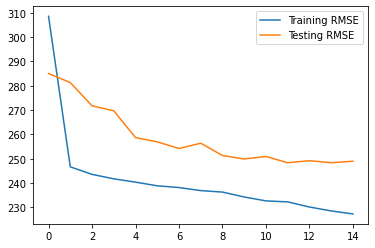

In [28]:
plt.plot(history3.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history3.history['val_root_mean_squared_error'], label='Testing RMSE')
plt.legend();

In [29]:
model4=Sequential() 


model4.add(Dense( #All the neurons in this layer are fully connected to all the neurons in the next layer
    units= 128, #how many neurons in the first hidden layer (we have 20 features so we wnat to use a number thats base 2 larger than the number of features)
    activation='relu', #always use relu for the activation until something better comes along
    input_shape=(95, ) # This tells the network the size of the input layer (8 features)

))

model4.add(BatchNormalization())

model4.add(Dense(units=180, activation='relu')) 
model4.add(Dense(units=128, activation='relu'))
model4.add(Dense(units=64, activation='relu')) 


"""
For regression problems, we want the output layer:
- Have one neuron (we are returning only one number- thats the prediction)
- Linear activations OR no activation 
"""

model4.add(Dense(units=1, activation='linear'))


"""
- Loss function - Mean Squared Error (its a regression problem)
- Optimizer - adam (until something better comes along)
- Metric - we'll use MSE
"""

model4.compile(loss='mae', optimizer='adam', metrics=['mse', 'RootMeanSquaredError'])

history4=model4.fit(X_train_sc, y_train, #the training data
          epochs= 15, # The number of epochs- number of "runs" or "passes" on the data
          batch_size=256, #no set formula, you'll get a feeling. Smaller batch size- it will run quicker but don't want to give too few, how many rows of data the model gets at once
          validation_data=(X_test_sc, y_test),
          verbose=0
         )

In [30]:
history4.history['root_mean_squared_error'][-1], history4.history['val_root_mean_squared_error'][-1]

(227.50457763671875, 250.5262908935547)

In [31]:
model5=Sequential() 


model5.add(Dense( #All the neurons in this layer are fully connected to all the neurons in the next layer
    units= 128, #how many neurons in the first hidden layer (we have 20 features so we wnat to use a number thats base 2 larger than the number of features)
    activation='relu', #always use relu for the activation until something better comes along
    input_shape=(95, ) # This tells the network the size of the input layer (8 features)

))



model5.add(Dense(units=180, activation='relu')) 
model5.add(Dense(units=128, activation='relu'))
model5.add(Dense(units=64, activation='relu')) 


"""
For regression problems, we want the output layer:
- Have one neuron (we are returning only one number- thats the prediction)
- Linear activations OR no activation 
"""

model5.add(Dense(units=1, activation='linear'))


"""
- Loss function - Mean Squared Error (its a regression problem)
- Optimizer - adam (until something better comes along)
- Metric - we'll use MSE
"""

model5.compile(loss='mae', optimizer='adam', metrics=['mse', 'RootMeanSquaredError'])

history5=model5.fit(X_train_sc, y_train, #the training data
          epochs= 15, # The number of epochs- number of "runs" or "passes" on the data
          batch_size=256, #no set formula, you'll get a feeling. Smaller batch size- it will run quicker but don't want to give too few, how many rows of data the model gets at once
          validation_data=(X_test_sc, y_test),
          verbose=0
         )

In [32]:
history5.history['root_mean_squared_error'][-1], history5.history['val_root_mean_squared_error'][-1]

(237.4395294189453, 251.98081970214844)

In [33]:
model6=Sequential() 


model6.add(Dense( #All the neurons in this layer are fully connected to all the neurons in the next layer
    units= 128, #how many neurons in the first hidden layer (we have 20 features so we wnat to use a number thats base 2 larger than the number of features)
    activation='relu', #always use relu for the activation until something better comes along
    input_shape=(95, ) # This tells the network the size of the input layer (8 features)

))



model6.add(Dense(units=180, activation='relu')) 
model6.add(Dropout(0.2))
model6.add(Dense(units=128, activation='relu'))
model6.add(Dropout(0.1))
model6.add(Dense(units=64, activation='relu')) 


"""
For regression problems, we want the output layer:
- Have one neuron (we are returning only one number- thats the prediction)
- Linear activations OR no activation 
"""

model6.add(Dense(units=1, activation='linear'))


"""
- Loss function - Mean Squared Error (its a regression problem)
- Optimizer - adam (until something better comes along)
- Metric - we'll use MSE
"""

model6.compile(loss='mae', optimizer='adam', metrics=['mse', 'RootMeanSquaredError'])

history6=model6.fit(X_train_sc, y_train, #the training data
          epochs= 15, # The number of epochs- number of "runs" or "passes" on the data
          batch_size=256, #no set formula, you'll get a feeling. Smaller batch size- it will run quicker but don't want to give too few, how many rows of data the model gets at once
          validation_data=(X_test_sc, y_test),
          verbose=0
         )

In [34]:
history6.history['root_mean_squared_error'][-1], history6.history['val_root_mean_squared_error'][-1]

(237.3788604736328, 251.6356658935547)

In [35]:
model7=Sequential()


model7.add(Dense( #All the neurons in this layer are fully connected to all the neurons in the next layer
    units= 128, #how many neurons in the first hidden layer (we have 20 features so we wnat to use a number thats base 2 larger than the number of features)
    activation='relu', #always use relu for the activation until something better comes along
    input_shape=(95, ) # This tells the network the size of the input layer (8 features)

))



model7.add(Dense(units=180, activation='relu')) 
#model7.add(Dropout(0.2))
model7.add(Dense(units=128, activation='relu'))
#model7.add(Dropout(0.1))
model7.add(Dense(units=64, activation='relu')) 


"""
For regression problems, we want the output layer:
- Have one neuron (we are returning only one number- thats the prediction)
- Linear activations OR no activation 
"""

model7.add(Dense(units=1, activation='linear'))


"""
- Loss function - Mean Squared Error (its a regression problem)
- Optimizer - adam (until something better comes along)
- Metric - we'll use MSE
"""

model7.compile(loss='mae', optimizer='adam', metrics=['mse', 'RootMeanSquaredError'])

early_stop = EarlyStopping(monitor = 'val_loss', min_delta=0, patience = 5, verbose = 1, mode = 'auto')

history7=model7.fit(X_train_sc, y_train, #the training data
          epochs= 75, # The number of epochs- number of "runs" or "passes" on the data
          batch_size=256, #no set formula, you'll get a feeling. Smaller batch size- it will run quicker but don't want to give too few, how many rows of data the model gets at once
          validation_data=(X_test_sc, y_test),
          verbose=0,
          callbacks = [early_stop]
         )

Epoch 00017: early stopping


In [36]:
history7.history['root_mean_squared_error'][-1], history7.history['val_root_mean_squared_error'][-1]

(234.4231414794922, 253.2106475830078)

## Conclusion

* Based on the modeling results above, we can see that our models performed very poorly in being able to explain the variability in deaths per 1000 residents. 5 models performed slightly better than the baseline or null model in terms of RMSE (Linear Regression, XGBoost, Random Forests Regressor, Bagging Regressor, and KNN Regressor). The simple linear regression performed the best, with a testing RMSE of 237.83. However, our R2 score was only 6.5%. Thus, we can conclude that the nursing home provider data was a poor predictor of covid deaths, as our best model could only explain 6.5% of the variability in covid deaths.